In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub

In [2]:
# Download latest version
path = kagglehub.dataset_download("denkuznetz/taxi-price-prediction")
print("Path to dataset files:", path)

100%|██████████| 19.6k/19.6k [00:00<00:00, 13.1MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/denkuznetz/taxi-price-prediction/versions/1


In [3]:
df = pd.read_csv('/root/.cache/kagglehub/datasets/denkuznetz/taxi-price-prediction/versions/1/taxi_trip_pricing.csv')

In [4]:
df.head()

,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
0,19.35,Morning,Weekday,3.0,Low,Clear,3.56,0.80,0.32,53.82,36.2624
1,47.59,Afternoon,Weekday,1.0,High,Clear,NaN,0.62,0.43,40.57,NaN
2,36.87,Evening,Weekend,1.0,High,Clear,2.70,1.21,0.15,37.27,52.9032
3,30.33,Evening,Weekday,4.0,Low,NaN,3.48,0.51,0.15,116.81,36.4698
4,NaN,Evening,Weekday,3.0,High,Clear,2.93,0.63,0.32,22.64,15.6180


In [5]:
def fill_nan_with_equation(df, column_name):
  if column_name == "Trip_Price":
    df[column_name] = df[column_name].fillna(
        df["Trip_Distance_km"] * df["Per_Km_Rate"] + df["Base_Fare"] + df["Per_Minute_Rate"] * df["Trip_Duration_Minutes"]
    )
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
  elif column_name == "Trip_Distance_km":
    df[column_name] = df[column_name].fillna(
        (df["Trip_Price"] - df["Base_Fare"] - df["Per_Minute_Rate"] * df["Trip_Duration_Minutes"])/ df["Per_Km_Rate"]
    )
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
  elif column_name == "Base_Fare":
    df[column_name] = df[column_name].fillna(
        df["Trip_Price"] - df["Trip_Distance_km"] * df["Per_Km_Rate"] - df["Per_Minute_Rate"] * df["Trip_Duration_Minutes"]
    )
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
  elif column_name == "Per_Minute_Rate":
    df[column_name] = df[column_name].fillna(
        (df["Trip_Price"] - df["Base_Fare"] - df["Trip_Distance_km"] * df["Per_Km_Rate"]) / df["Trip_Duration_Minutes"]
    )
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
  elif column_name == "Per_Km_Rate":
    df[column_name] = df[column_name].fillna(
        (df["Trip_Price"] - df["Base_Fare"] - df["Per_Minute_Rate"] * df["Trip_Duration_Minutes"]) / df["Trip_Distance_km"]
    )
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
  elif column_name == "Trip_Duration_Minutes":
    df[column_name] = df[column_name].fillna(
        (df["Trip_Price"] - df["Base_Fare"] - df["Per_Minute_Rate"] * df["Trip_Distance_km"]) / df["Per_Km_Rate"]
    )
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')

  return df


taxi = fill_nan_with_equation(df, "Trip_Price")
taxi = fill_nan_with_equation(df, "Trip_Distance_km")
taxi = fill_nan_with_equation(df, "Base_Fare")
taxi = fill_nan_with_equation(df, "Per_Minute_Rate")
taxi = fill_nan_with_equation(df, "Per_Km_Rate")
taxi = fill_nan_with_equation(df, "Trip_Duration_Minutes")

In [6]:
taxi["Trip_Price"] = taxi["Trip_Price"].fillna(taxi["Trip_Price"].mean())
taxi["Trip_Distance_km"] = taxi["Trip_Distance_km"].fillna(taxi["Trip_Distance_km"].mean())
taxi["Base_Fare"] = taxi["Base_Fare"].fillna(taxi["Base_Fare"].mean())
taxi["Per_Minute_Rate"] = taxi["Per_Minute_Rate"].fillna(taxi["Per_Minute_Rate"].mean())
taxi["Per_Km_Rate"] = taxi["Per_Km_Rate"].fillna(taxi["Per_Km_Rate"].mean())
taxi["Trip_Duration_Minutes"] = taxi["Trip_Duration_Minutes"].fillna(taxi["Trip_Duration_Minutes"].mean())

In [7]:
X = taxi[['Trip_Distance_km', 'Base_Fare', 'Per_Km_Rate', 'Trip_Duration_Minutes']].values

In [8]:
y = taxi['Trip_Price'].values
y = y.reshape(-1,1)

In [9]:
ones_column = np.ones((X.shape[0], 1))
X_new = np.hstack((ones_column, X))

In [10]:
m = X_new.T@X_new
n = np.linalg.inv(m)
g = n@X_new.T
w = g@y

In [11]:
y_pred = X_new@w

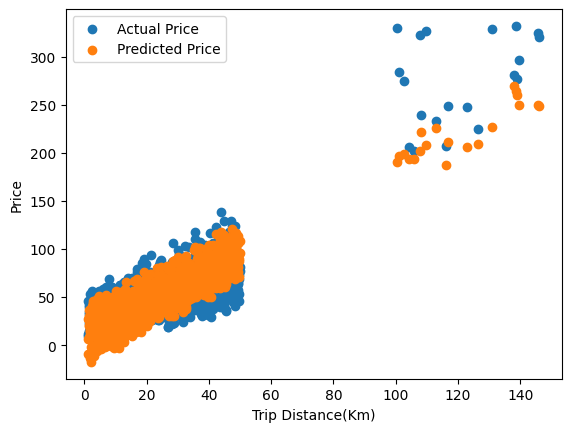

In [12]:
plt.scatter(X_new[:,1], y, label = 'Actual Price')
plt.scatter(X_new[:,1], y_pred, label = 'Predicted Price')
plt.xlabel('Trip Distance(Km)')
plt.ylabel('Price')
plt.legend()
plt.show()

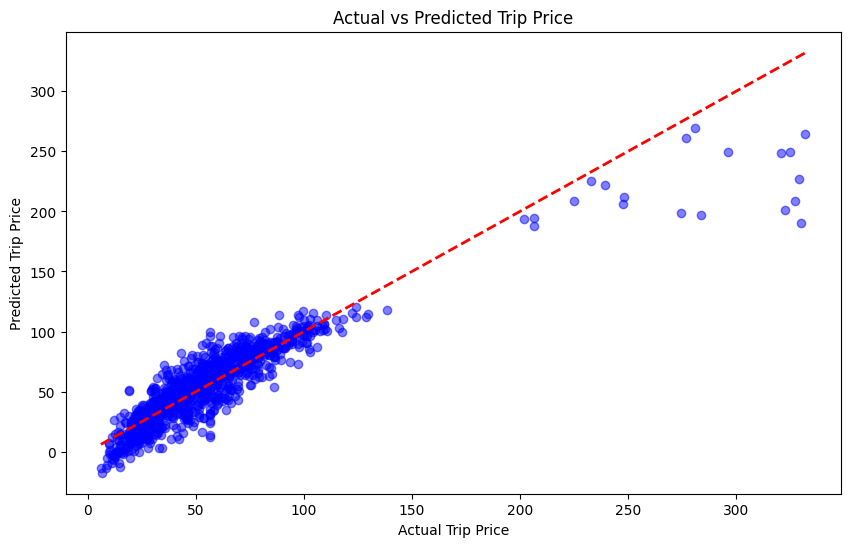

In [13]:
plt.figure(figsize=(10,6))
plt.scatter(y, y_pred, color='blue', alpha=0.5)
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--', lw=2)  # Diagonal line (perfect prediction)
plt.xlabel('Actual Trip Price')
plt.ylabel('Predicted Trip Price')
plt.title('Actual vs Predicted Trip Price')
plt.show()

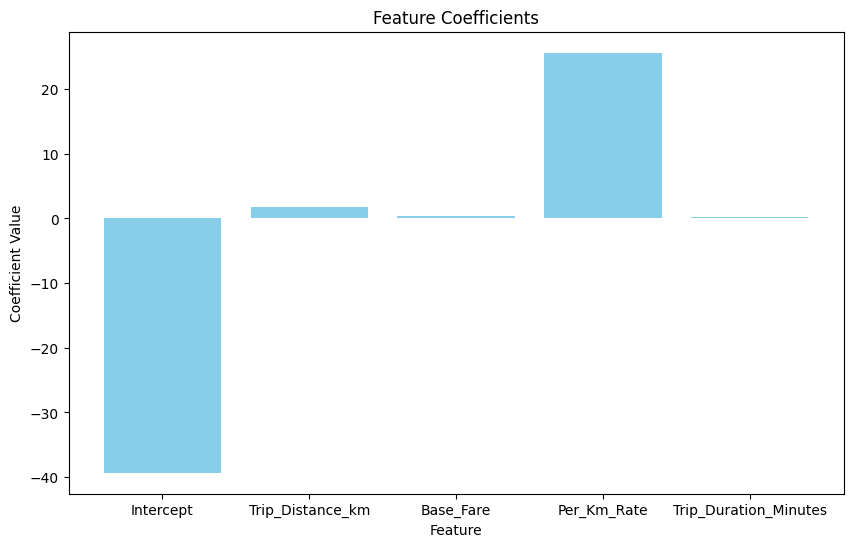

In [14]:
#Plot coefficients
features = ['Intercept', 'Trip_Distance_km', 'Base_Fare', 'Per_Km_Rate', 'Trip_Duration_Minutes']
coefficients = w.flatten()

plt.figure(figsize=(10,6))
plt.bar(features, coefficients, color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Coefficient Value')
plt.title('Feature Coefficients')
plt.show()

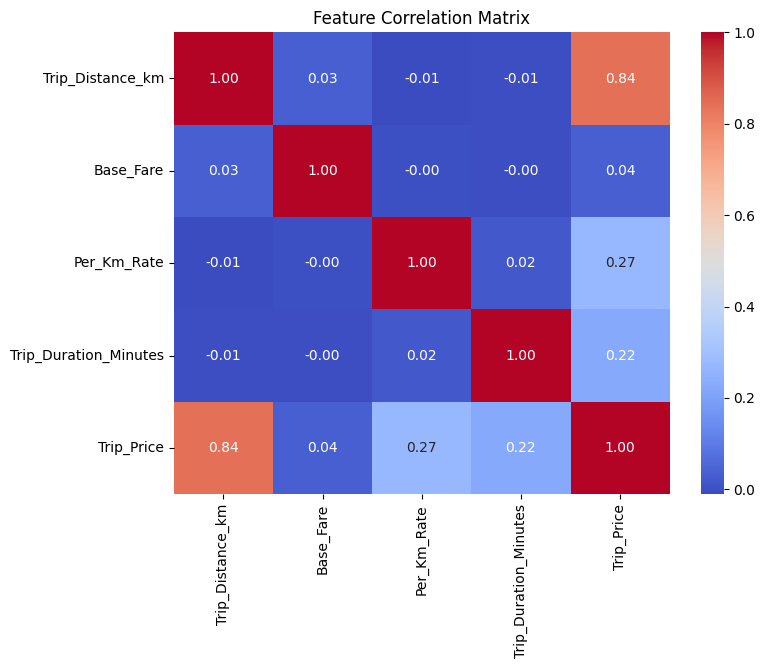

In [15]:
import seaborn as sns

# Create a DataFrame for the features and target
taxi_data = taxi[['Trip_Distance_km', 'Base_Fare', 'Per_Km_Rate', 'Trip_Duration_Minutes', 'Trip_Price']]

# Calculate correlation matrix
correlation_matrix = taxi_data.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Feature Correlation Matrix')
plt.show()


In [16]:
f = y - X_new@w
sig = f.T@f
sig = sig/X_new.shape[0]
sig

array([[257.34234476]])

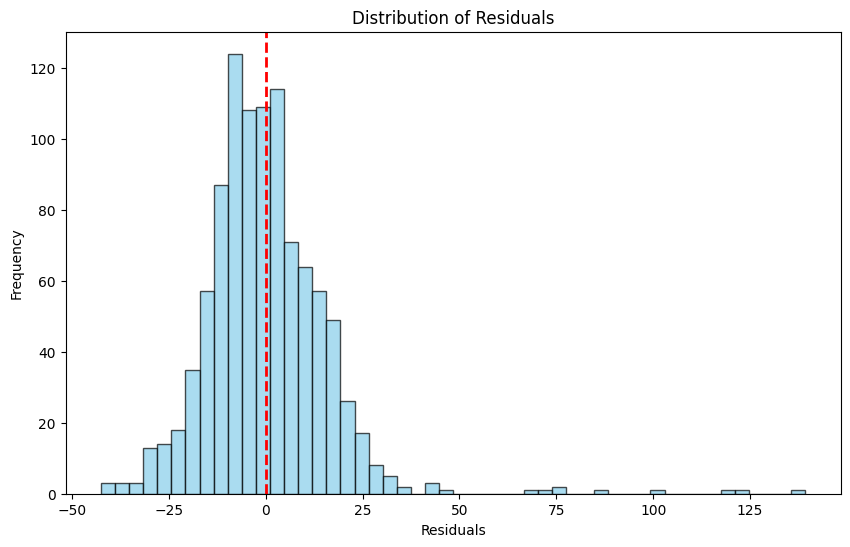

In [17]:
plt.figure(figsize=(10, 6))
plt.hist(f.flatten(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', lw=2)  # Line at zero
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

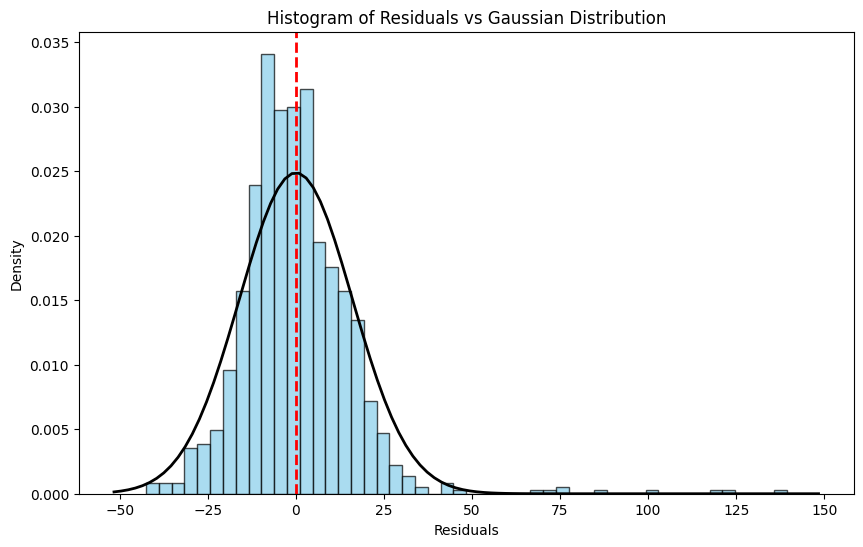

In [19]:
import scipy.stats as stats
plt.figure(figsize=(10, 6))
plt.hist(f.flatten(), bins=50, color='skyblue', edgecolor='black', alpha=0.7, density=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, 0, np.sqrt(sig))
p = p.flatten()
plt.plot(x, p, 'k', linewidth=2)
plt.axvline(0, color='red', linestyle='--', lw=2)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Histogram of Residuals vs Gaussian Distribution')
plt.show()